In [1]:
import pandas as pd
import requests 
from io import StringIO
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import geopandas as gpd
from shapely import ops
from shapely import geometry as geom
import os
import urllib
#from sjoin import sjoin
%matplotlib inline

### Intro to taxi trip data

The taxicabs of New York City come in two varieties: yellow and green.

Taxis painted canary __yellow__ (medallion taxis) are able to pick up passengers *__anywhere__ in the five boroughs.* 

Those painted apple __green__ (street hail livery vehicles,or commonly known as boro taxis), which began to appear in August 2013, are *allowed to pick up passengers in __Upper Manhattan__, the Bronx, Brooklyn, Queens (excluding LaGuardia Airport and John F. Kennedy International Airport), and Staten Island.*

--from wiki['Taxicabs of New York City'](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City)--

### Data set
We will use 

    `Yellow Taxi Trip Data from 2010 to 2015` 
    `Green Taxi Trip Data from 2013 to 2014`
    
    
which are accessible through __NYC OpenData__:

[2010 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2010-Yellow-Taxi-Trip-Data/ry9a-ubra)
168,994,353 rows

[2011 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2011-Yellow-Taxi-Trip-Data/jr6k-xwua)
135,335,924 rows 

[2012 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2012-Yellow-Taxi-Trip-Data/fd5y-xikb)
167,331,308 rows

[2013 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2013-Yellow-Taxi-Trip-Data/7rnv-m532)
173,179,759 rows

[2013 Green Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2013-Green-Taxi-Trip-Data/ghpb-fpea)
about 1.21M rows

[2014 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2015-Yellow-Taxi-Trip-Data/ba8s-jw6u)
165,114,361 rows

[2014 Green Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2014-Green-Taxi-Trip-Data/2np7-5jsg)
about 15.8M rows

The total data size for five years is too big to be handled by our computer, so we decided to take a subset - sample - based on the payment related criteria. 

The subset sampleing criteria:

For all data, we will only consider trip records - rows - provided by **[VeriFone, inc.](http://www.verifone.com/industries/taxi/)**- one of major companies that provides taxi payment system. These records are marked as `VTS` on `vendorid` (or `vendor_id`) column. 

For each year, we will sample 100,000 records. Among the 100,000 sample, 50% will be cash payment records and the other 50% will be credit payment record. For the years 2013 and 2014, we will adjust the sampling size of yellow taxi and green taxi for each year, so that the size are proportional to their number of total rows per sum of yellow rows and green rows.  

The total size of our subset data - sample for our taxi data set - will be ** 500,000 ** rows. (= 100,000 rows * 5 years)

### 1. Read in yellow taxi trip data

In [2]:
# source urls for yellow taxi trip data in NYC between 2010 and 2014 
source = ['https://data.cityofnewyork.us/resource/74wj-s5ij.json', #[0] 2010 yellow taxi
          'https://data.cityofnewyork.us/resource/uwyp-dntv.json', #[1] 2011 yellow taxi
          'https://data.cityofnewyork.us/resource/kerk-3eby.json', #[2] 2012 yellow taxi
          'https://data.cityofnewyork.us/resource/t7ny-aygi.json', #[3] 2013 yellow taxi
          'https://data.cityofnewyork.us/resource/h4pe-ymjc.json', #[4] 2013 green taxi
          'https://data.cityofnewyork.us/resource/gkne-dk5s.json', #[5] 2014 yellow taxi
          'https://data.cityofnewyork.us/resource/7j25-xd5y.json'] #[6] 2014 green taxi

#### Test Yellow Taxi Dataset for 2010 to validate data before read in all source urls.

In [34]:
# for 2014 samples, 

# read 91,266 rows from yellow taxi, then
YTD_14_CRD = source[5] + '?vendor_id=VTS&payment_type=CRD&$limit=45633'
YTD_14_CSH = source[5] + '?vendor_id=VTS&payment_type=CSH&$limit=45633'
Y14CRD = pd.read_json(YTD_14_CRD)  # 45,633 rows
Y14CSH = pd.read_json(YTD_14_CSH)  # 45,633 rows
yellow14 = Y14CRD.append(Y14CSH)
print(yellow14.shape) # 91,266 rows

(91266, 17)


In [35]:
# read the rest 8,734 rows from green taxi
GTD_14_CRD = source[6] + '?vendorid=2&payment_type=1&$limit=4367'
GTD_14_CSH = source[6] + '?vendorid=2&payment_type=2&$limit=4367'
G14CRD = pd.read_json(GTD_14_CRD)  # 4,367 rows
G14CSH = pd.read_json(GTD_14_CSH)  # 4,367 rows
green14 = G14CRD.append(G14CSH)
print(green14.shape) # 8,734 rows

(8734, 19)


### 2. Preprocess the taxi data
** Fix different colunm names. **
The columns in the *Green taxi data-set* contains columns that are identical to the columns in yellow taxi dataset but with different column name; so we want to make sure that the column names are the same so that we can append the the two data frames

In [36]:
# observe the difference in column names
yellow14.columns.values

array(['dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude',
       'fare_amount', 'imp_surcharge', 'mta_tax', 'passenger_count',
       'payment_type', 'pickup_datetime', 'pickup_latitude',
       'pickup_longitude', 'rate_code', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_distance', 'vendor_id'], dtype=object)

In [37]:
green14.columns.values

array(['dropoff_latitude', 'dropoff_longitude', 'extra', 'fare_amount',
       'lpep_dropoff_datetime', 'lpep_pickup_datetime', 'mta_tax',
       'passenger_count', 'payment_type', 'pickup_latitude',
       'pickup_longitude', 'ratecodeid', 'store_and_fwd_flag',
       'tip_amount', 'tolls_amount', 'total_amount', 'trip_distance',
       'trip_type', 'vendorid'], dtype=object)

In [38]:
#TD_13 = [yellow13, green13]
TD_14 = [yellow14, green14] # [raw_data_Y14,raw_data_G14]

def match_col(list_df):
    for i in range(len(list_df)):
        for j in list_df[i].columns.values:
            if j == 'lpep_dropoff_datetime':# or j == 'tpep_dropoff_datetime':
                list_df[i].rename(columns={j: 'dropoff_datetime' }, inplace=True)
            if j == 'lpep_pickup_datetime':#   or j == 'tpep_pickup_datetime':
                list_df[i].rename(columns={j: 'pickup_datetime' }, inplace=True)

#match_col(TD_13)
match_col(TD_14)

# confirm the change
#print("Columns for Green Taxi:\n", G_M_14.columns.values)
#print()
#print("Columns for Yellow Taxi:\n", Y_M_14.columns.values)

Columns for Green Taxi:
 ['dropoff_latitude' 'dropoff_longitude' 'extra' 'fare_amount'
 'dropoff_datetime' 'pickup_datetime' 'mta_tax' 'passenger_count'
 'payment_type' 'pickup_latitude' 'pickup_longitude' 'ratecodeid'
 'store_and_fwd_flag' 'tip_amount' 'tolls_amount' 'total_amount'
 'trip_distance' 'trip_type' 'vendorid']

Columns for Yellow Taxi:
 ['dropoff_datetime' 'dropoff_latitude' 'dropoff_longitude' 'fare_amount'
 'imp_surcharge' 'mta_tax' 'passenger_count' 'payment_type'
 'pickup_datetime' 'pickup_latitude' 'pickup_longitude' 'rate_code'
 'tip_amount' 'tolls_amount' 'total_amount' 'trip_distance' 'vendor_id']


**Refine the data-sets so that it only contain the columns we need.** Then, append the green taxi dataset to yellow taxi dataset because they have the same columns after refining the columns.

In [39]:
def needed_col(data):
    cols_y = ['dropoff_latitude', 'dropoff_longitude','dropoff_datetime' , 'pickup_datetime',
              'pickup_latitude','pickup_longitude','tip_amount','trip_distance']
    refine_data = pd.DataFrame(data, columns = cols_y)
    return (refine_data)

Processed_YTD = needed_col(yellow14)
processed_GTD = needed_col(green14)
Taxi_Data_14  = Processed_YTD.append(processed_GTD)
Taxi_Data_14.shape #(100000, 8) 

(100000, 8)

### 3. Get map data for Queens

In [40]:
# map data for NYC
zipgeojson = "https://github.com/YuHuaCheng/Map/raw/master/data/nyc-zip-code-tabulation-areas-polygons.geojson"

# read the NYC map data
zipsfile = os.path.join("data",zipgeojson.split("/")[-1])

try:
    NZ = gpd.read_file(zipsfile) # NYC map data with Zipcode
except OSError as e:
    urllib.request.urlretrieve(zipgeojson, zipsfile)
    
    #zips geojson had a var assignment that caused problems
    fin      = open(zipsfile)
    
    lines    = [line for line in fin]
    lines[0] = lines[0].replace("var nycdata = ", "")
    
    fin.close()
    
    fout = open(zipsfile, "w")
    for line in lines:
        fout.write(line)
    fout.flush()
    fout.close()
    
    NZ = gpd.read_file(zipsfile)
    
NZ.shape # NYC is composed of 262 subarea on the map data

(262, 12)

In [46]:
# NYC map data with Zipcode
NZ.head(3)

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040


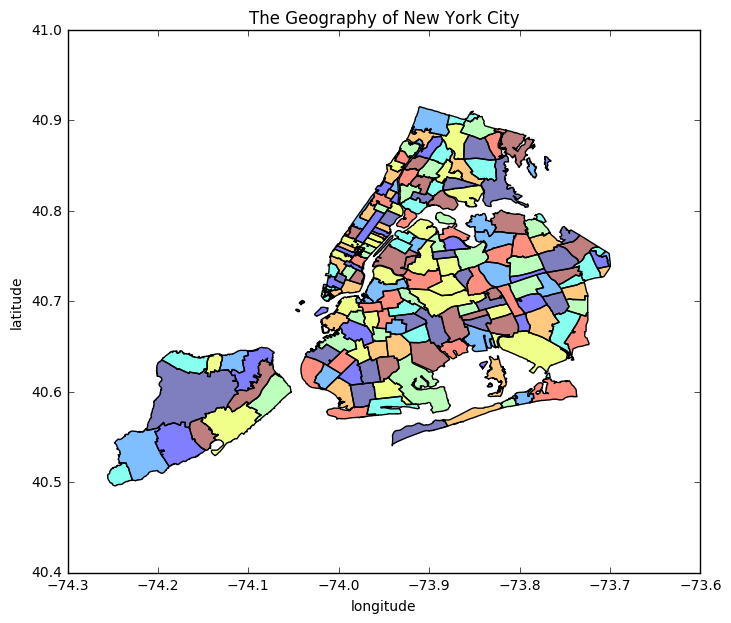

In [41]:
# draw the map data for New York City
NZ.plot(figsize=(14,7))
plt.title("The Geography of New York City")
plt.xlabel("longitude")
plt.ylabel("latitude")

In [84]:
# seperate Queens map data from NYC map data
QN = NZ[NZ.borough=='Queens']
QN = QN.reset_index()

In [83]:
QN.head(3)

,index,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040


In [85]:
# number of different zipcodes in Queens
#print("number of zip codes in Queens: ", QN.postalCode.unique().shape[0]) # 67

# number of shape areas in QN data
print("number of shape areas in Queens: ", QN.Shape_Area.unique().shape[0]) # 70

number of shape areas in Queens:  70


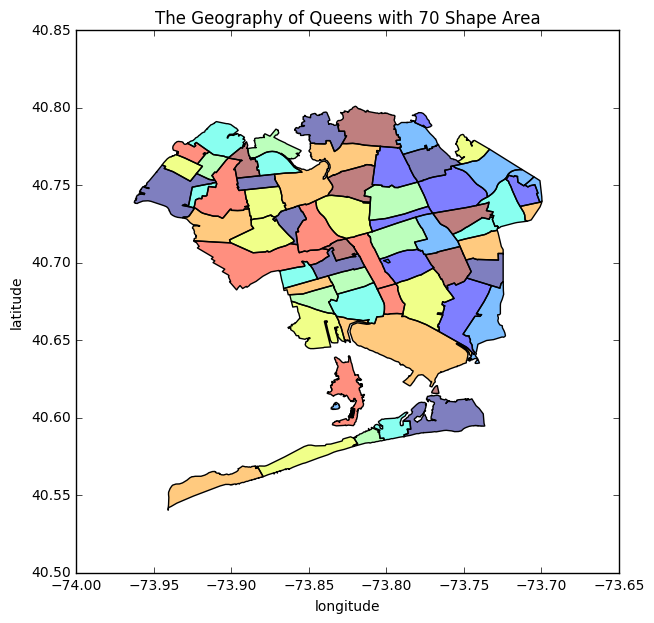

In [86]:
# draw Queens
QN.plot(figsize=(14,7))
plt.title("The Geography of Queens with 70 Sub Area") # <~~~~~~~~~~~~~~ editted it for each shape doesn't mean zip
plt.xlabel("longitude")
plt.ylabel("latitude")

### 4. Apply taxi data into Queens map data

**1) Process taxi data to make it applicable to map data**

In [102]:
# take pickup latitude and longitude pairs from taxi data, and transform the pair into points 
def cov_latlon_POINT(dataframe): 
    pickup_latlon = []
    for i in range (len(dataframe)):
        pickup_latlon.append(geom.Point(dataframe.pickup_longitude.iloc[i],
                                        dataframe.pickup_latitude.iloc[i]))
    PickupP_df      = gpd.GeoSeries(pickup_latlon)
    PickupP_df      = PickupP_df[PickupP_df.values != 'POINT (0.0 0.0)'] #get rid of 0.0 0.0 lon-lat points
    GeoPickup_Point = gpd.GeoDataFrame(geometry=PickupP_df)
    return (GeoPickup_Point)

GeoPickup = cov_latlon_POINT(Taxi_Data_14)
print(GeoPickup.shape)
GeoPickup.head()

(100000, 1)


,geometry
0,POINT (-73.97772999999999 40.752252)
1,POINT (-73.981925 40.765817)
2,POINT (-73.95799 40.76505)
3,POINT (-73.991945 40.729295)
4,POINT (-73.985197 40.75655)


** 2) Apply the pickup points into Queens map. **

In [100]:
# take point data and map data, and return a list of the point lists within the geometry of the map data
def points_in_region(points, region): # <~~~~~~~~~~~~~~ editted it from "City_only_Points(GeoP)"
    within_region = []
    for i in range(len(region)):
        point_in_sub_area = points[points.geometry.within(region.geometry[i])]
        within_region.append(point_in_sub_area) 
    return(within_region)

QN_only = points_in_region(GeoPickup, QN)

In [106]:
sum_  = 0
for i in range (len(QN_only)):
    sum_ = sum_ + len(QN_only[i])
print("Total number of Trips in QN out of 100,000 Trips for Year 2014: ", sum_)

Total number of Trips in Queens out of 100,000 Trips for Year 2014:  7225


Based on our subset of size 100,000, Queens accounts For *** 7.225 % *** of all Yellow-Green taxi trips that happened in 2014 

In [116]:
QN_per_Zip = {}
for i in range(len(QN_only)):
    QN_per_Zip[i] = len(QN_only[i])

In [117]:
col = ['Number of Trips']

In [118]:
QN_per_Zip_df = pd.DataFrame.from_dict(QN_per_Zip, orient='index')

In [119]:
QN_per_Zip_df.rename(columns={0: "Num Trips per Zip in QN"}, inplace = True)

In [120]:
QN_per_Zip_df['ZIP'] = QN.postalCode.values

In [121]:
QN_per_Zip_df.head()

,Num Trips per Zip in QN,ZIP
0,232,11372
1,0,11004
2,0,11040
3,0,11426
4,3,11365


In [122]:
max_trip = QN_per_Zip_df.sort_values('Num Trips per Zip in QN', ascending = False)
max_trip.head()

,Num Trips per Zip in QN,ZIP
31,1925,11371
60,1712,11430
45,598,11101
5,338,11373
40,338,11103


In [123]:
max_val = max_trip.reset_index()
print ("The max trips made per is Zip-Code is: ", max_val.loc[0]['Num Trips per Zip in QN'])
print ("The ZipCode that it Corresponds to is: ", max_val.loc[0].ZIP)

The max trips made per is Zip-Code is:  1925
The ZipCode that it Corresponds to is:  11371


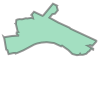

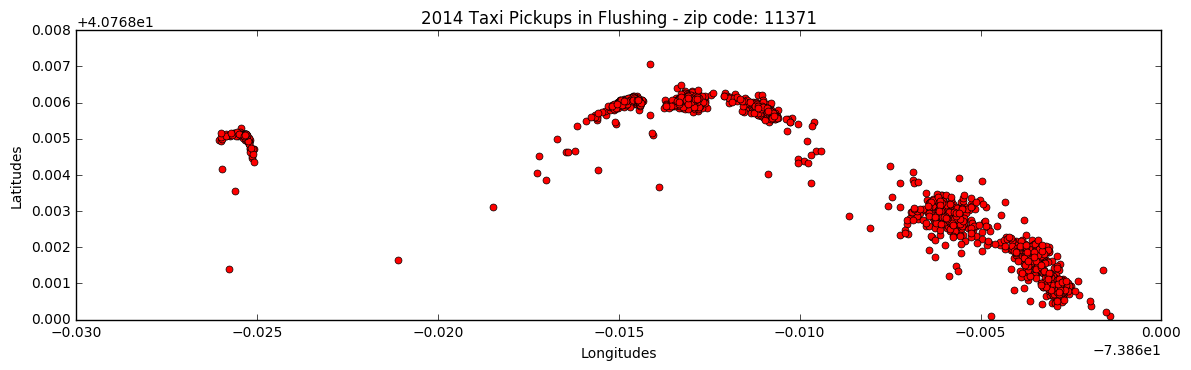

In [127]:
Plot_11371 = GeoPickup_QN[GeoPickup_QN.geometry.within(QN.geometry[31])]
QN.geometry[31]
Plot_11371.plot(marker='o', color='red', markersize=5, figsize=(14,7))
plt.title("2014 Taxi Pickups in " + QN.PO_NAME.iloc[31] + " - zip code: " + str(QN.postalCode.iloc[31]))
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
QN.geometry[31]

In [104]:
#################################################################################### up to here for now

will repeat "4.1) and 4.2)"  with the rest dataset; 2013, 2012, 2011, 2010 